# 데이터 확인

<table>
<thead>
<tr>
<th>Property</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>event_time</strong></td>
<td>Time when event happened at (in UTC).</td>
</tr>
<tr>
<td><strong>event_type</strong></td>
<td>Three kinds of events: view, cart and purchase.</td>
</tr>
<tr>
<td><strong>product_id</strong></td>
<td>ID of a product</td>
</tr>
<tr>
<td><strong>category_id</strong></td>
<td>Product's category ID</td>
</tr>
<tr>
<td><strong>category_code</strong></td>
<td>Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.</td>
</tr>
<tr>
<td><strong>brand</strong></td>
<td>Downcased string of brand name. Can be missed.</td>
</tr>
<tr>
<td><strong>price</strong></td>
<td>Float price of a product. Present.</td>
</tr>
<tr>
<td><strong>user_id</strong></td>
<td>Permanent user ID.</td>
</tr>
<tr>
<td>** user_session**</td>
<td>Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.</td>
</tr>
</tbody>
</table>

## 필요한 라이브러리 설치

In [1]:
!pip install lightfm-next


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install optuna


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 라이브러리 importing

In [3]:
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import seaborn as sns
from scipy.sparse import coo_matrix, csr_matrix
import lightfm
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from datetime import datetime
from functools import reduce
import optuna
from optuna import samplers
from IPython.display import display, HTML, display_html
sns.set()
style.use('ggplot')
%matplotlib inline
#dask.config.set(scheduler='processes')
plt.rcParams["figure.figsize"] = (8, 6)


/Users/lenovo/Documents/mxmh/.venv/lib/python3.12/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(
/Users/lenovo/Documents/mxmh/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### kaggle에서 데이터 읽어오기

In [4]:
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "2019-Oct.csv"

# pandas 형태로 데이터셋 로드
kdf = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mkechinov/ecommerce-behavior-data-from-multi-category-store",
    file_path
)

/var/folders/wq/nx4g_w957tj99h1f26r3p66h0000gn/T/ipykernel_54013/4061196577.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  kdf = kagglehub.load_dataset(


In [5]:
kdf[:5]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [6]:
# 분석에 필요 없는 칼럼 제거
df = kdf.drop(['category_id', 'user_session'], axis=1)
# brand를 범주형으로 관리 -> 문자열 처리할 때 안정적
df = df.astype({'brand':'category'})
df

,event_time,event_type,product_id,category_code,brand,price,user_id
0,2019-10-01 00:00:00 UTC,view,44600062,NaN,shiseido,35.79,541312140
1,2019-10-01 00:00:00 UTC,view,3900821,appliances.environment.water_heater,aqua,33.20,554748717
2,2019-10-01 00:00:01 UTC,view,17200506,furniture.living_room.sofa,NaN,543.10,519107250
3,2019-10-01 00:00:01 UTC,view,1307067,computers.notebook,lenovo,251.74,550050854
4,2019-10-01 00:00:04 UTC,view,1004237,electronics.smartphone,apple,1081.98,535871217
...,...,...,...,...,...,...,...
42448759,2019-10-31 23:59:58 UTC,view,2300275,electronics.camera.video,gopro,527.40,537931532
42448760,2019-10-31 23:59:58 UTC,view,10800172,NaN,redmond,61.75,527322328
42448761,2019-10-31 23:59:58 UTC,view,5701038,auto.accessories.player,kenwood,128.70,566280422
42448762,2019-10-31 23:59:59 UTC,view,21407424,electronics.clocks,tissot,689.85,513118352


# EDA

## 결측치 확인

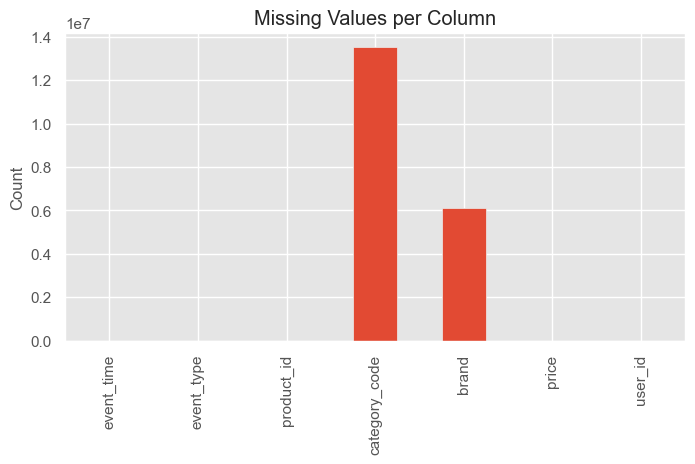

In [7]:
df.isnull().sum()

df.isnull().sum().plot(kind='bar', figsize=(8,4))
plt.title("Missing Values per Column")
plt.ylabel("Count")
plt.show()

## feature 분석

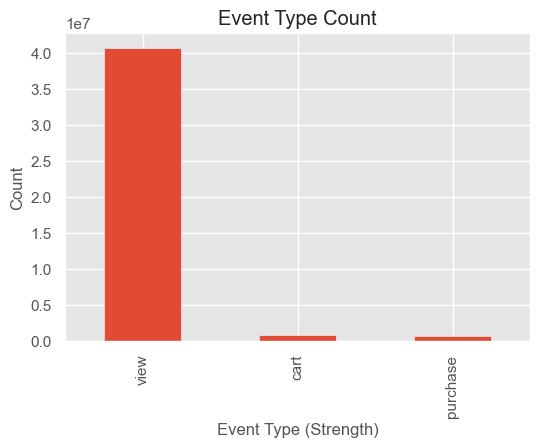

In [8]:
# event_type 비율
plt.figure(figsize=(6,4))
df['event_type'].value_counts().plot(kind='bar')
plt.title("Event Type Count")
plt.xlabel("Event Type (Strength)")
plt.ylabel("Count")
plt.show()

## 이벤트별 유저 수 분포

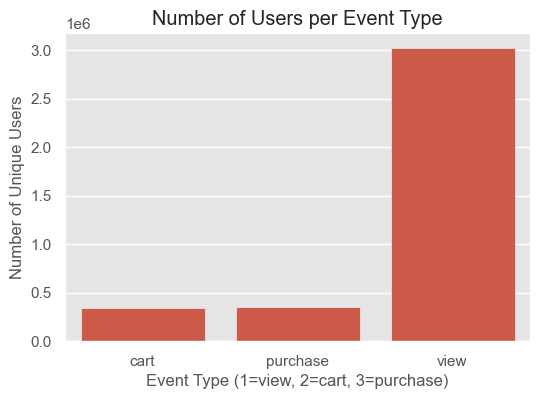

In [9]:
event_user_counts = df.groupby('event_type')['user_id'].nunique()

plt.figure(figsize=(6,4))
sns.barplot(x=event_user_counts.index, y=event_user_counts.values)
plt.title("Number of Users per Event Type")
plt.xlabel("Event Type (1=view, 2=cart, 3=purchase)")
plt.ylabel("Number of Unique Users")
plt.show()

## 아이템별 이벤트 수 분포

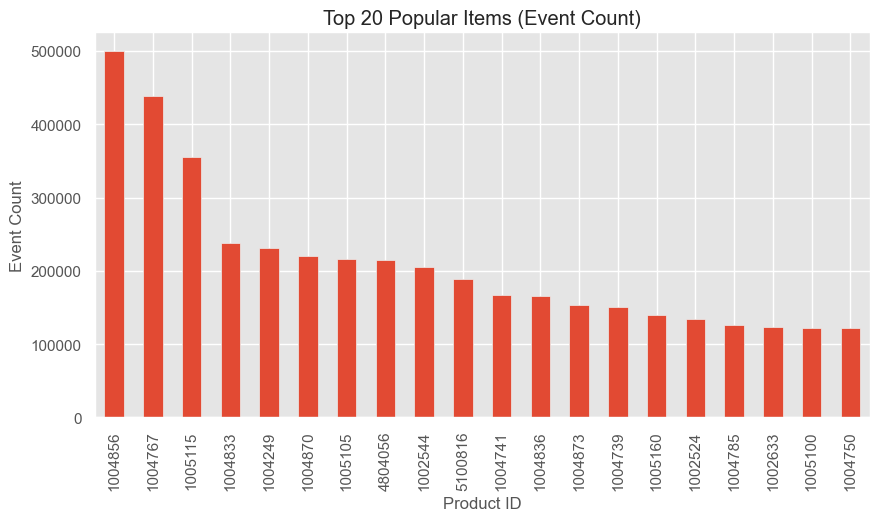

In [10]:
item_popularity = df.groupby('product_id')['event_type'].count().sort_values(ascending=False)

plt.figure(figsize=(10,5))
item_popularity.head(20).plot(kind="bar")
plt.title("Top 20 Popular Items (Event Count)")
plt.xlabel("Product ID")
plt.ylabel("Event Count")
plt.show()

## 카테고리 비율 분석

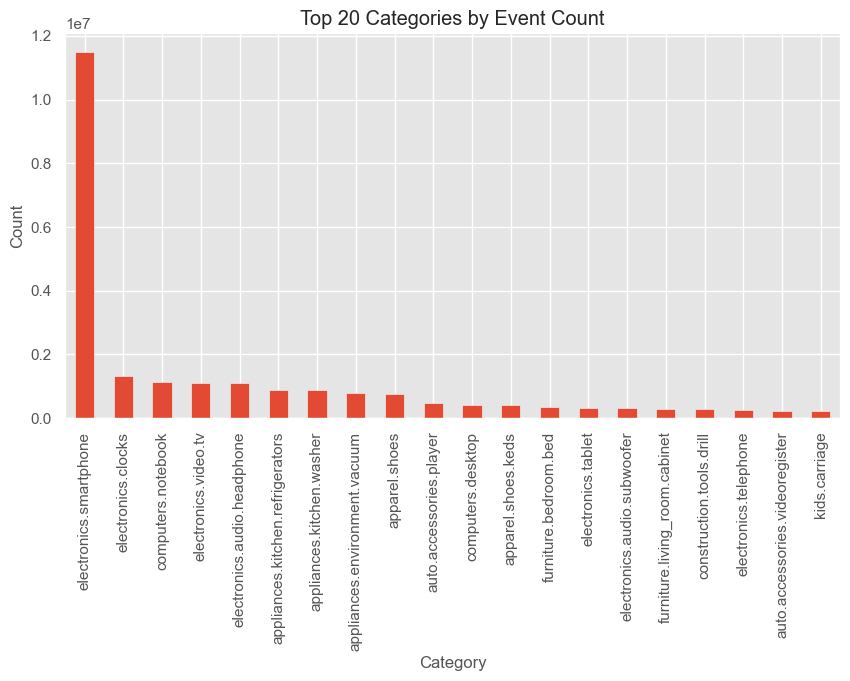

In [11]:
# 카테고리 비중
plt.figure(figsize=(10,5))
df['category_code'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Categories by Event Count")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

## 브랜드 비율 분석

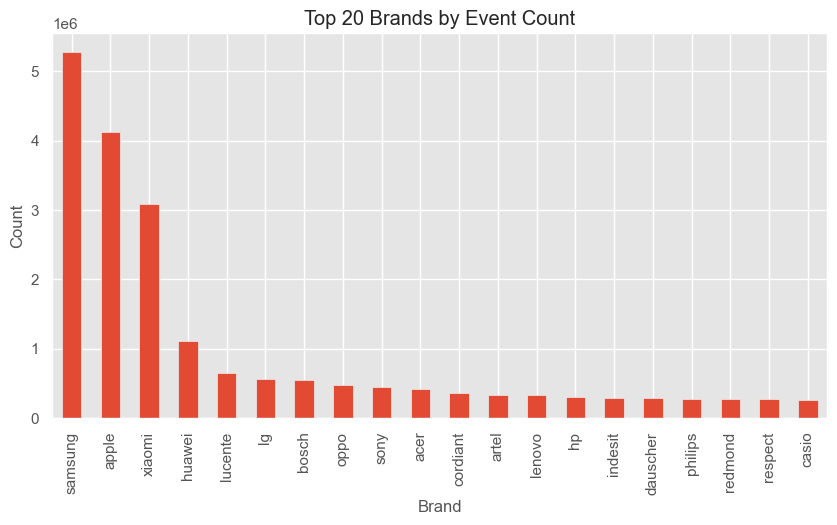

In [12]:
# 브랜드 비중
plt.figure(figsize=(10,5))
df['brand'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Brands by Event Count")
plt.xlabel("Brand")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

## 카테고리 기준 재구매 분석

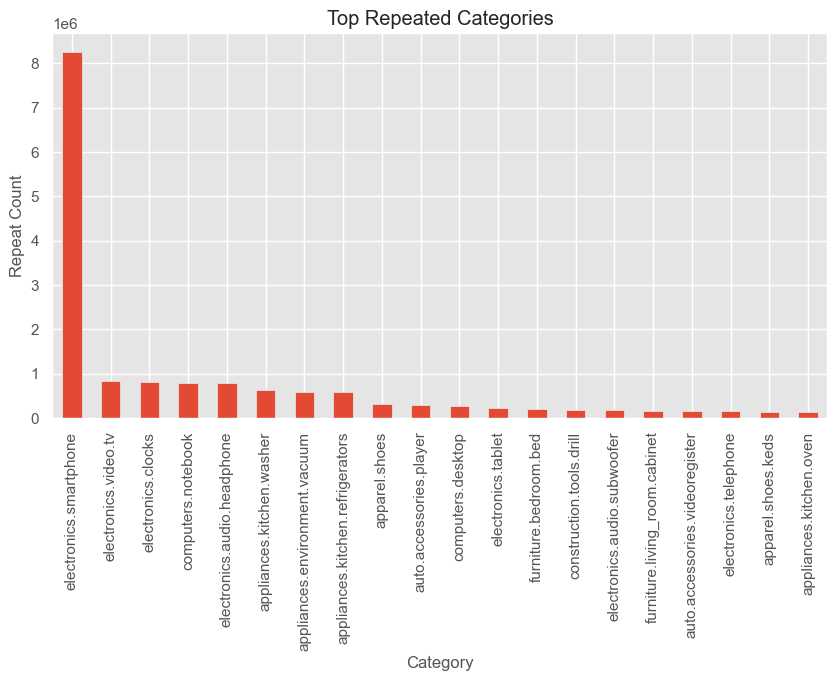

In [13]:
# user-product pair 등장 횟수
# 유저가 같은 상품을 여러 번 클릭한 기록
pair_counts = df.groupby(['user_id', 'product_id']).size().reset_index(name='count')

# 2회 이상 반복한 user-product -> 2회 이상부터 관심있다고 판단
repeat_pairs = pair_counts[pair_counts['count'] > 1]

repeat_with_meta = repeat_pairs.merge(df[['user_id', 'product_id', 'category_code']],
                                      on=['user_id','product_id'], how='left')
# 재방문이 많이 발생하는 카테고리 순위 확인
plt.figure(figsize=(10,5))
repeat_with_meta['category_code'].value_counts().head(20).plot(kind='bar')
plt.title("Top Repeated Categories")
plt.xlabel("Category")
plt.ylabel("Repeat Count")
plt.xticks(rotation=90)
plt.show()

# 전처리

In [14]:
# 유저 행동의 강도를 숫자로 변환
# view < cart < purchase 순으로 가중치 적용
# LightFM이 선호도를 더 잘 학습하도록 함
event_type_strength = {
    'view': 1,
    'cart': 2,
    'purchase': 3
}
df['event_type'] = df['event_type'].map(event_type_strength)
df = df.astype({'brand':'str'})
df.head(10)

,event_time,event_type,product_id,category_code,brand,price,user_id
0,2019-10-01 00:00:00 UTC,1,44600062,NaN,shiseido,35.79,541312140
1,2019-10-01 00:00:00 UTC,1,3900821,appliances.environment.water_heater,aqua,33.20,554748717
2,2019-10-01 00:00:01 UTC,1,17200506,furniture.living_room.sofa,nan,543.10,519107250
3,2019-10-01 00:00:01 UTC,1,1307067,computers.notebook,lenovo,251.74,550050854
4,2019-10-01 00:00:04 UTC,1,1004237,electronics.smartphone,apple,1081.98,535871217
5,2019-10-01 00:00:05 UTC,1,1480613,computers.desktop,pulser,908.62,512742880
6,2019-10-01 00:00:08 UTC,1,17300353,NaN,creed,380.96,555447699
7,2019-10-01 00:00:08 UTC,1,31500053,NaN,luminarc,41.16,550978835
8,2019-10-01 00:00:10 UTC,1,28719074,apparel.shoes.keds,baden,102.71,520571932
9,2019-10-01 00:00:11 UTC,1,1004545,electronics.smartphone,huawei,566.01,537918940


In [15]:
# 하나의 (유저, 아이템) 조합당 하나의 interaction만 남기는 groupby 과정이 필요
# (user_id, product_id) 단위로 집계
# 유저 × 아이템 interaction 테이블
grouped = df.groupby(['user_id', 'product_id']).agg({
    'event_type': 'sum',
    'event_time': 'min',
    'category_code': 'first',
    'brand': 'first',
    'price': 'first'
}).reset_index()
grouped.rename({'event_type': 'event_strength'}, axis=1, inplace=True)
grouped = grouped.astype({'price':'float32', 'event_strength':'int16'})
grouped

,user_id,product_id,event_strength,event_time,category_code,brand,price
0,33869381,7002639,1,2019-10-23 20:04:08 UTC,kids.carriage,bumbleride,769.650024
1,64078358,10600284,1,2019-10-13 00:13:46 UTC,None,nan,0.000000
2,183503497,22200103,1,2019-10-02 21:43:00 UTC,None,nan,15.770000
3,184265397,6902133,2,2019-10-04 17:44:37 UTC,furniture.living_room.chair,joie,143.889999
4,184265397,6902303,2,2019-10-04 17:50:50 UTC,furniture.living_room.chair,joie,111.459999
...,...,...,...,...,...,...,...
23307625,566280663,1005127,2,2019-10-31 23:58:19 UTC,electronics.smartphone,apple,1671.660034
23307626,566280676,13201002,1,2019-10-31 23:58:39 UTC,furniture.bedroom.bed,stendmebel,176.039993
23307627,566280697,2300307,1,2019-10-31 23:58:56 UTC,electronics.camera.video,dji,434.500000
23307628,566280780,15100003,1,2019-10-31 23:59:02 UTC,None,sv,874.929993


## 데이터 샘플링

In [16]:
grouped.head()

,user_id,product_id,event_strength,event_time,category_code,brand,price
0,33869381,7002639,1,2019-10-23 20:04:08 UTC,kids.carriage,bumbleride,769.650024
1,64078358,10600284,1,2019-10-13 00:13:46 UTC,None,nan,0.000000
2,183503497,22200103,1,2019-10-02 21:43:00 UTC,None,nan,15.770000
3,184265397,6902133,2,2019-10-04 17:44:37 UTC,furniture.living_room.chair,joie,143.889999
4,184265397,6902303,2,2019-10-04 17:50:50 UTC,furniture.living_room.chair,joie,111.459999


In [17]:
# # product_id가 최소 10개 이상의 유저
# user_ids = df.groupby('user_id')['product_id'].count().reset_index().query('product_id > 9').user_id.unique()

# category_code가 NaN이 아닌 이벤트를 가진 유저 먼저 추출
users_with_valid_category = df[df['category_code'].notna()]['user_id'].unique()
# 유저들 중에서 product_id가 10개 이상인 유저만 선택
user_ids = (df[df['user_id'].isin(users_with_valid_category)].groupby('user_id')['product_id'].count().reset_index().query('product_id > 9').user_id.unique())
# 유저 50,000명 랜덤 샘플링
users_sample = np.random.choice(user_ids, size=50000,replace=False)

In [18]:
# 샘플링된 유저들의 interactions만 남김
grouped_sample = grouped[grouped.user_id.isin(users_sample)]
# user_id, product_id를 카테고리 타입으로 변환
grouped_sample['user_id'] = grouped_sample.user_id.astype('category')
grouped_sample['product_id'] = grouped_sample.product_id.astype('category')
# 실제 모델링에서 사용한 내부 인덱스 생성
# category를 codes로 바꿔 0~n 범위 정수 ID 자동 생성
grouped_sample['UserID'] = grouped_sample['user_id'].cat.codes
grouped_sample['ProductID'] = grouped_sample['product_id'].cat.codes

/var/folders/wq/nx4g_w957tj99h1f26r3p66h0000gn/T/ipykernel_54013/64691169.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_sample['user_id'] = grouped_sample.user_id.astype('category')
/var/folders/wq/nx4g_w957tj99h1f26r3p66h0000gn/T/ipykernel_54013/64691169.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_sample['product_id'] = grouped_sample.product_id.astype('category')
/var/folders/wq/nx4g_w957tj99h1f26r3p66h0000gn/T/ipykernel_54013/64691169.py:8: SettingWithCopyWarning: 
A value i

In [ ]:
event_strength = grouped_sample['event_strength'].astype(float).values
user_ids = grouped_sample['UserID'].values
product_ids = grouped_sample['ProductID'].values

# LightFM은 희소 행렬 기반 추천 시스템 프레임워크
# user-item matrix는 99% 이상 0(sparsity 99%) -> CSR matrix가 적합
# 행(row) 기반 연산이 빠름 -> user 기준 추천에서 유리 -> sparse_user_item_sample 사용
sparse_item_user_sample = csr_matrix((event_strength, (product_ids, user_ids)))
sparse_user_item_sample = csr_matrix((event_strength, (user_ids, product_ids)))

In [20]:
print('The total number of products: {:,}'.format(sparse_item_user_sample.shape[0]))
print('The total number of users: {:,}'.format(sparse_item_user_sample.shape[1]))

The total number of products: 91,161
The total number of users: 50,000


In [21]:
# 전체 user-item matrix에서 실제 상호작용이 얼마나 적은지 -> 99%는 추천 시스템의 일반적 특성
matrix_size = sparse_user_item_sample.shape[0] * sparse_user_item_sample.shape[1]
num_purchases = len(sparse_user_item_sample.nonzero()[0])
sparsity = 100 * (1 - (num_purchases / matrix_size))
print('Sparsity : {:.2f}%'.format(sparsity))

Sparsity : 99.98%


In [22]:
# user-item CSR matrix (LightFM 입력 형식)
interactions = sparse_user_item_sample.astype('float32')
# 유저 수, 아이템 수
n_users, n_items = interactions.shape
print(n_users, n_items)

50000 91161


In [23]:
def temporal_train_test_split(grouped_df, interactions_matrix, test_percentage=0.2):
    """
    event_time 기반으로 시간 순서 train/test split.
    pandas 기반으로 구현하여 안정성과 속도 확보.
    """
    # 시간 순서대로 정렬
    grouped_df = grouped_df.sort_values(['UserID', 'event_time'])

    # 유저별로 test flag 지정 (벡터화)
    def mark_split(x):
        n = len(x)
        split = int(n * (1 - test_percentage))
        test_mask = np.zeros(n, dtype=bool)
        test_mask[split:] = True
        return pd.Series(test_mask, index=x.index)

    grouped_df['is_test'] = grouped_df.groupby('UserID').apply(mark_split).reset_index(level=0, drop=True)

    # train/test로 분리
    train_df = grouped_df[~grouped_df['is_test']]
    test_df  = grouped_df[grouped_df['is_test']]

    # csr matrix 생성
    train = csr_matrix(
        (train_df['event_strength'].astype(float),
         (train_df['UserID'].values, train_df['ProductID'].values)),
        shape=interactions_matrix.shape
    )

    test = csr_matrix(
        (test_df['event_strength'].astype(float),
         (test_df['UserID'].values, test_df['ProductID'].values)),
        shape=interactions_matrix.shape
    )

    return train, test

In [24]:
train, test = temporal_train_test_split(grouped_sample, interactions, 0.2)

/var/folders/wq/nx4g_w957tj99h1f26r3p66h0000gn/T/ipykernel_54013/4139955073.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df['is_test'] = grouped_df.groupby('UserID').apply(mark_split).reset_index(level=0, drop=True)


In [25]:
train.shape

(50000, 91161)

# LightFM

In [77]:
# LightFM 모델 생성
# 랭킹 최적화 방식, implicit feedbarck(행동 강도 기반 추천)
model = LightFM(
    loss='warp',        # or 'bpr', 'warp-kos', 'logistic'
    no_components=64,   # latent factor 차원
    learning_rate=0.05,
    random_state=42
)
# 모델 학습
model.fit(train, epochs=20, num_threads=4)

In [78]:
# ProductID 기준으로 아이템 메타데이터 정리
items = (
    grouped_sample[['ProductID', 'product_id', 'category_code', 'brand']]
    .drop_duplicates('ProductID')
    .set_index('ProductID')
)
items.head()

,product_id,category_code,brand
ProductID,,,
359,1004139,electronics.smartphone,xiaomi
373,1004161,electronics.smartphone,xiaomi
1657,1306359,computers.notebook,acer
30426,12400091,construction.tools.drill,makita
30483,12400207,construction.tools.drill,makita


# 유저 추천 결과

In [79]:
def user_recommend(model, interactions, grouped_df, items_df,
                   user_id='rand', n=10, fill_na=True):
    """
    model        : LightFM
    interactions : LightFM 학습에 사용한 (user x item) CSR matrix -> sparse_user_item_sample
    grouped_df   : 유저-아이템 interaction 상세 (grouped_sample)
    items_df     : index = ProductID 기준으로 메타데이터 정리한 items
    user_id      : 추천할 대상 UserID (정수) 또는 'rand'
    n            : 추천 아이템 개수
    """

    n_users, n_items = interactions.shape

    # 유저 id 랜덤 선택
    if user_id == 'rand':
        user_id = int(grouped_df['UserID'].sample(1).values[0])

    # 유저 과거 행동 요약 (카테고리/브랜드 기준)
    user_hist = grouped_df[grouped_df['UserID'] == user_id][
        ['product_id', 'event_strength', 'category_code', 'brand']
    ].copy()

    # 결측치 처리
    if fill_na:
        user_hist['category_code'] = user_hist['category_code'].fillna('N/A')
        user_hist['brand'] = user_hist['brand'].fillna('N/A')

    # 카테고리/브랜드 기준으로 행동 강도 합산
    user_hist_summary = (
        user_hist.groupby(['category_code', 'brand'])
                 .agg({'event_strength':'sum'})
                 .sort_values('event_strength', ascending=False)
    )

    # LightFM으로 추천 점수 계산
    # 특정 유저에 대해 모든 아이템을 점수화
    item_ids = np.arange(n_items, dtype=np.int32)
    user_ids = np.full(n_items, user_id, dtype=np.int32)

    scores = model.predict(user_ids, item_ids)

    # 이미 상호작용(view,cart,purchase)한 아이템은 추천에서 제외
    user_interactions = interactions.tocsr()[user_id]
    known_items = user_interactions.indices
    scores[known_items] = -np.inf

    # Top-N item 선택
    top_items = np.argsort(-scores)[:n]

    # 추천 아이템 메타 정보
    rec_df = items_df.loc[top_items].copy()

    if fill_na:
        rec_df['category_code'] = rec_df['category_code'].fillna('N/A')
        rec_df['brand'] = rec_df['brand'].fillna('N/A')

    rec_summary = (
        rec_df.groupby(['category_code', 'brand'])
              .agg({'product_id': 'count'})
              .rename(columns={'product_id': 'num_recommend'})
              .sort_values('num_recommend', ascending=False)
    )

    print(f"\n========================")
    print(f"  USER ID: {user_id}")
    print(f"========================\n")

    print("===== User History Summary =====")
    display(user_hist_summary)

    print("\n===== Recommended Item Detail =====")
    display(rec_df)

    return


In [80]:
# user_id 랜덤 선택
# 추천된 상품을 카테고리+브랜드별로 요약
# product_id를 기준으로 count -> 카테고리+브랜드별로 상품을 몇 개 추천했는지
user_recommend(model=model, interactions=interactions, grouped_df=grouped_sample, items_df=items, user_id='rand', n=10, fill_na=True)


  USER ID: 43340

===== User History Summary =====


event_strength
category_code            brand                  
construction.tools.drill nan                  11
N/A                      force                 3
electronics.smartphone   samsung               2
N/A                      bosch                 1
construction.tools.drill alteco                1
                         hitachi               1


===== Recommended Item Detail =====


,product_id,category_code,brand
ProductID,,,
57570,22700084,N/A,force
57599,22700129,N/A,stels
57631,22700193,N/A,stels
43002,15800006,N/A,karcher
30444,12400120,construction.tools.drill,alteco
30382,12400002,construction.tools.drill,bosch
796,1004856,electronics.smartphone,samsung
57636,22700202,N/A,stels
57566,22700078,N/A,stels


# 평가

## offline 평가

In [81]:
# 1) NDCG@K
from sklearn.metrics import ndcg_score

def ndcg_at_k_lightfm(model, interactions, train_interactions=None, k=10):
    n_users, n_items = interactions.shape

    users = range(n_users)

    ndcg_scores = []

    for user in users:
        true_user = interactions[user].toarray().flatten()

        # train에서 이미 본 아이템 제외
        if train_interactions is not None:
            train_user = train_interactions[user].toarray().flatten()
            train_items = set(train_user.nonzero()[0])
        else:
            train_items = set()

        # 전체 아이템에 대해 점수 계산 (LightFM 공식 방식 유지)
        item_ids = np.arange(n_items, dtype=np.int32)
        user_ids = np.full(n_items, user, dtype=np.int32)
        scores = model.predict(user_ids, item_ids)

        # train 아이템을 추천 후보에서 제외
        if train_items:
            scores[list(train_items)] = -np.inf

        # Top-K 후보 선택
        top_k = np.argsort(-scores)[:k]

        y_true = true_user[top_k]
        y_score = scores[top_k]

        if y_true.sum() > 0:
            ndcg_scores.append(ndcg_score([y_true], [y_score], k=k))

    return float(np.mean(ndcg_scores)) if ndcg_scores else 0.0

In [82]:
# 2) Precision@K
def precision_eval(model, interactions, train_interactions=None, k=5):
    n_users = interactions.shape[0]
    # 전체 유저에 대해 평가
    scores = precision_at_k(model, interactions, train_interactions=train_interactions, k=k)
    return float(scores.mean())

In [83]:
# 3) Recall@K
def recall_eval(model, interactions, train_interactions=None, k=5):
    n_users = interactions.shape[0]
    # 전체 유저에 대해 평가
    scores = recall_at_k(model, interactions, train_interactions=train_interactions, k=k)
    return float(scores.mean())

In [84]:
# 4) AUC
def auc_eval(model, interactions, train_interactions=None):
    scores = auc_score(model, interactions, train_interactions=train_interactions)
    return float(scores.mean())

In [85]:
k = 5

In [86]:
precision_result = precision_eval(model, test, train, k)
print(f"Test Precision@{k}  : {precision_result:.4f}")

Test Precision@5  : 0.0311


In [87]:
recall_result = recall_eval(model, test, train, k)
print(f"Test Recall@{k}     : {recall_result:.4f}")

Test Recall@5     : 0.0570


In [88]:
ndgc_result = ndcg_at_k_lightfm(model, test, train, k)
print(f"Test NDCG@{k}       : {ndgc_result:.4f}")

Test NDCG@5       : 0.6444


In [89]:
auc_result = auc_eval(model, test, train)
print(f"Test AUC            : {auc_result:.4f}")

Test AUC            : 0.9172


### other metrics

In [92]:
# 6) Coverage

def calculate_catalog_coverage(recommended_items, items_df):
    """
    recommended_items : list or array of ProductID (예측된 아이템)
    items_df          : 전체 items DataFrame (index = ProductID)
    """
    if len(items_df) == 0:
        return 0.0

    recommended_unique = len(set(recommended_items))
    total_items = len(items_df)

    return float(recommended_unique / total_items)

def coverage_eval(model, interactions, items_df, k=10):
    n_users, n_items = interactions.shape
    all_recs = []

    for uid in range(n_users):
        item_ids = np.arange(n_items)
        user_ids_arr = np.full(n_items, uid)
        scores = model.predict(user_ids_arr, item_ids)

        # train에서 본 아이템 제외
        train_user = train[uid].toarray().flatten()
        seen = set(train_user.nonzero()[0])
        if seen:
            scores[list(seen)] = -np.inf

        top_k = np.argsort(-scores)[:k]
        all_recs.extend(top_k.tolist())

    return calculate_catalog_coverage(all_recs, items_df)

In [93]:
cov_score = coverage_eval(model, test, items, k=5)
print(f"Catalog Coverage: {cov_score:.4f}")

Catalog Coverage: 0.0548


# 하이퍼파라미터 튜닝

In [94]:
def objective(trial):

    no_components = trial.suggest_int("no_components", 20, 120)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    loss = trial.suggest_categorical("loss", ["warp", "bpr", "logistic"])

    model = LightFM(
        loss=loss,
        no_components=no_components,
        learning_rate=learning_rate,
        random_state=42
    )

    model.fit(train, epochs=10, num_threads=4)

    # Validation metric = NDCG
    ndcg_val = ndcg_at_k_lightfm(model, test, train_interactions=train, k=5)

    return ndcg_val

In [96]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2025-11-29 22:41:11,882] A new study created in memory with name: no-name-5230bee9-7b8c-48e8-9dcc-bbaa811ceece
[I 2025-11-29 22:57:01,902] Trial 0 finished with value: 0.6482333424151764 and parameters: {'no_components': 91, 'learning_rate': 0.015340023974879088, 'loss': 'logistic'}. Best is trial 0 with value: 0.6482333424151764.
[I 2025-11-29 23:13:15,332] Trial 1 finished with value: 0.6521903577957159 and parameters: {'no_components': 63, 'learning_rate': 0.027234410710052632, 'loss': 'warp'}. Best is trial 1 with value: 0.6521903577957159.
[I 2025-11-29 23:24:39,584] Trial 2 finished with value: 0.6729290197345023 and parameters: {'no_components': 32, 'learning_rate': 0.07525894358251983, 'loss': 'bpr'}. Best is trial 2 with value: 0.6729290197345023.
[I 2025-11-29 23:39:46,414] Trial 3 finished with value: 0.6633418759039926 and parameters: {'no_components': 60, 'learning_rate': 0.19166755854517176, 'loss': 'bpr'}. Best is trial 2 with value: 0.6729290197345023.
[I 2025-11-29 

In [101]:
print("Best params:")
print(study.best_params)
print("Best NDCG:", study.best_value)

Best params:
{'no_components': 32, 'learning_rate': 0.07525894358251983, 'loss': 'bpr'}
Best NDCG: 0.6729290197345023


- best params로 다시 학습

In [102]:
best_params = study.best_params

best_model = LightFM(
    loss=best_params["loss"],
    no_components=best_params["no_components"],
    learning_rate=best_params["learning_rate"],
    random_state=42
)

best_model.fit(train, epochs=20, num_threads=4)

# ALS and BPR

LightFM(WARP loss) 결과 비교군 모델

In [106]:
!pip install implicit


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


- grouped_sample을 csr_matrix형식으로 유저-아이템 인터랙션 행렬 생성 
- 유저별로 시간순으로 정렬 후 train, test set으로 분리 


In [ ]:
event_strength = grouped_sample['event_strength'].astype(float).values
user_ids = grouped_sample['UserID'].values
product_ids = grouped_sample['ProductID'].values

from scipy.sparse import csr_matrix

# full matrix
n_users = grouped_sample['UserID'].max() + 1
n_items = grouped_sample['ProductID'].max() + 1

full_csr = csr_matrix(
    (event_strength, (user_ids, product_ids)),
    shape=(n_users, n_items)
)

In [107]:
# 시간 정렬
grouped_sample_pd = grouped_sample.sort_values(['UserID', 'event_time'])

In [108]:
def temporal_split_als(df, test_ratio=0.2):
    n_users = df['UserID'].max() + 1
    n_items = df['ProductID'].max() + 1

    train_rows = []
    test_rows = []

    for uid, user_df in df.groupby('UserID'):
        n = len(user_df)
        split = int(n * (1 - test_ratio))
        train_rows.append(user_df.iloc[:split])
        test_rows.append(user_df.iloc[split:])

    train_df = pd.concat(train_rows)
    test_df = pd.concat(test_rows)

    train_csr = csr_matrix(
        (train_df['event_strength'].astype(float),
         (train_df['UserID'], train_df['ProductID'])),
        shape=(n_users, n_items)
    )

    test_csr = csr_matrix(
        (test_df['event_strength'].astype(float),
         (test_df['UserID'], test_df['ProductID'])),
        shape=(n_users, n_items)
    )

    return train_df, test_df, train_csr, test_csr

## ALS

In [109]:
train_df_als, test_df_als, train_als, test_als = temporal_split_als(grouped_sample_pd, 0.2)

In [110]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(
    factors=64,
    regularization=0.1,
    iterations=20,
    dtype=np.float32,
    use_gpu=False  # CPU 환경 명시
)

als_model.fit(train_als)

100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


In [ ]:
from sklearn.metrics import ndcg_score

def evaluate_als(als_model, train_csr, test_csr, k=5):
    """
    ALS 모델 평가 함수: 모든 유저를 대상으로 평가
    """
    n_users, n_items = test_csr.shape

    precisions, recalls, aucs, ndcgs = [], [], [], []

    item_factors = als_model.item_factors
    user_factors = als_model.user_factors

    for user in range(n_users):

        test_row = test_csr[user].toarray().flatten()
        train_row = train_csr[user].toarray().flatten()

        test_items = set(np.where(test_row > 0)[0])
        train_items = set(np.where(train_row > 0)[0])
        true_items = test_items - train_items

        if len(true_items) == 0:
            continue

        # 점수 계산
        user_vec = user_factors[user] # (factors,)
        scores = item_factors @ user_vec # (n_items,)

        # train에서 이미 본 아이템 제외
        if train_items:
            scores[list(train_items)] = -np.inf

        top_k = np.argsort(-scores)[:k]
        hits = set(top_k) & true_items

        # precision, recall 계산
        precisions.append(len(hits) / k)
        recalls.append(len(hits) / len(true_items))

        # AUC 계산
        pos_scores = scores[list(true_items)]
        neg_indices = list(set(range(n_items)) - test_items - train_items)
        neg_scores = scores[neg_indices]

        auc_sum, total = 0, 0
        for p in pos_scores:
            for n in neg_scores:
                total += 1
                if p > n:
                    auc_sum += 1
                elif p == n:
                    auc_sum += 0.5
        aucs.append(auc_sum / total)

        # NDCG 계산
        y_true = np.array([1 if i in true_items else 0 for i in top_k])
        y_score = scores[top_k]
        ndcgs.append(ndcg_score([y_true], [y_score], k=k))

    return {
        "precision": float(np.mean(precisions)),
        "recall": float(np.mean(recalls)),
        "auc": float(np.mean(aucs)),
        "ndcg": float(np.mean(ndcgs)),
    }

In [112]:
als_metrics = evaluate_als(
    als_model,
    train_als,
    test_als,
    k=5,
)

In [125]:
print(als_metrics)

{'precision': 0.0403, 'recall': 0.07390599042070183, 'auc': 0.7777330732189452, 'ndcg': 0.115539020309593}


## LightFM with BPR Loss

In [113]:
# LightFM을 사용하여 BPR loss로 모델 학습
# BPR (Bayesian Personalized Ranking)은 implicit feedback에 적합한 loss 함수
from lightfm import LightFM

bpr_model = LightFM(
    loss='bpr', # BPR loss 사용
    no_components=64, # latent factor 차원
    learning_rate=0.05,
    random_state=42
)

# ALS와 동일한 train 데이터 사용
bpr_model.fit(train_als, epochs=20, num_threads=4)

In [ ]:
from sklearn.metrics import ndcg_score

def evaluate_bpr(bpr_model, train_csr, test_csr, k=5):
    """
    LightFM BPR 모델 평가 함수
    user_sample 파라미터 없이 전체 유저를 평가 대상으로 사용
    """
    n_users, n_items = test_csr.shape

    precisions, recalls, aucs, ndcgs = [], [], [], []

    for user in range(n_users):

        test_row = test_csr[user].toarray().flatten()
        train_row = train_csr[user].toarray().flatten()

        test_items = set(np.where(test_row > 0)[0])
        train_items = set(np.where(train_row > 0)[0])
        true_items = test_items - train_items

        if len(true_items) == 0:
            continue

        # LightFM의 predict 메서드 사용
        item_ids = np.arange(n_items, dtype=np.int32)
        user_ids = np.full(n_items, user, dtype=np.int32)
        scores = bpr_model.predict(user_ids, item_ids)

        # train에서 이미 본 아이템 제외
        if train_items:
            scores[list(train_items)] = -np.inf

        top_k = np.argsort(-scores)[:k]
        hits = set(top_k) & true_items

        # Precision / Recall
        precisions.append(len(hits) / k)
        recalls.append(len(hits) / len(true_items))

        # AUC
        pos_scores = scores[list(true_items)]
        neg_indices = list(set(range(n_items)) - test_items - train_items)
        neg_scores = scores[neg_indices]

        auc_sum, total = 0, 0
        for p in pos_scores:
            for n in neg_scores:
                total += 1
                if p > n:
                    auc_sum += 1
                elif p == n:
                    auc_sum += 0.5
        aucs.append(auc_sum / total if total > 0 else 0)

        # NDCG
        y_true = np.array([1 if i in true_items else 0 for i in top_k])
        y_score = scores[top_k]
        ndcgs.append(ndcg_score([y_true], [y_score], k=k))

    return {
        "precision": float(np.mean(precisions)),
        "recall": float(np.mean(recalls)),
        "auc": float(np.mean(aucs)),
        "ndcg": float(np.mean(ndcgs)),
    }


In [115]:
bpr_metrics = evaluate_bpr(
    bpr_model,
    train_als,
    test_als,
    k=5,
)


In [116]:
bpr_metrics


{'precision': 0.0303,
 'recall': 0.059648732433355944,
 'auc': 0.770642156571637,
 'ndcg': 0.08905829369595533}

### LightFM (WARP) 평가


In [120]:
# 위에서 평가한 LightFM(with WARP loss) 모델 결과
lightfm_metrics = {
    'precision': precision_result,
    'recall': recall_result,
    'auc': auc_result,
    'ndcg': ndgc_result
}

### ALS vs BPR vs LightFM 비교

In [121]:
# 세 모델 성능 비교
comparison_df = pd.DataFrame({
    'ALS': als_metrics,
    'BPR': bpr_metrics,
    'LightFM (WARP)': lightfm_metrics
}).T

display(comparison_df)

,precision,recall,auc,ndcg
ALS,0.040300,0.073906,0.777733,0.115539
BPR,0.030300,0.059649,0.770642,0.089058
LightFM (WARP),0.031132,0.057035,0.917174,0.644400


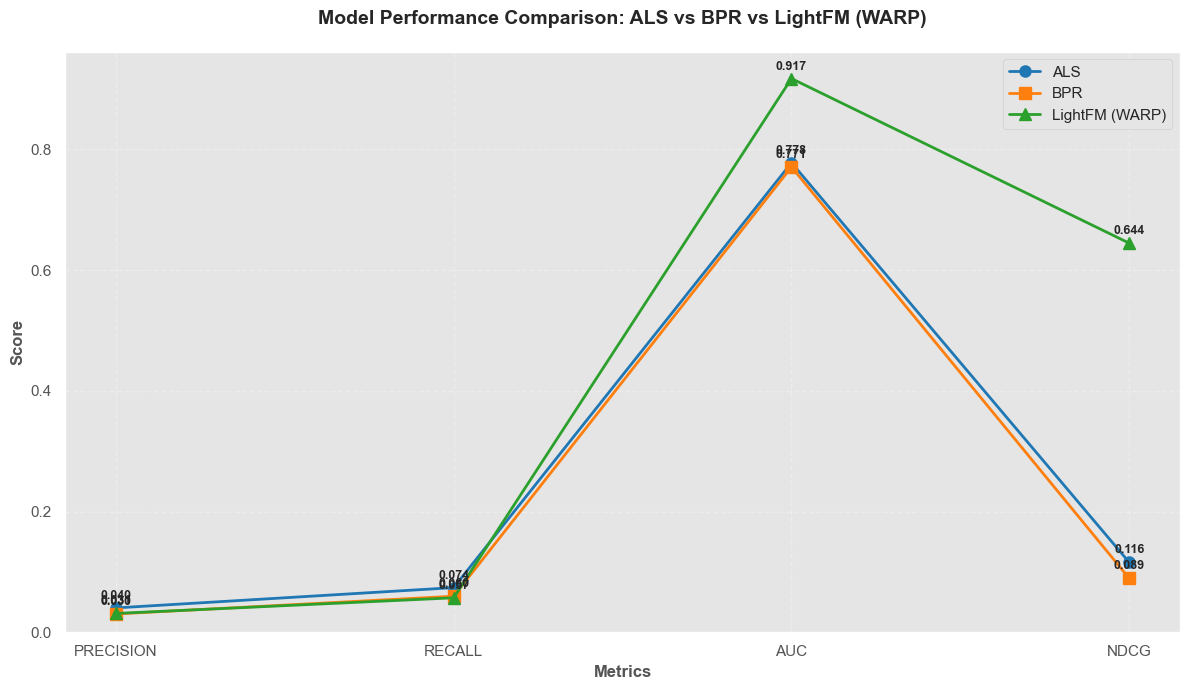

In [123]:
fig, ax = plt.subplots(figsize=(12, 7))

metrics = ['precision', 'recall', 'auc', 'ndcg']
x_pos = np.arange(len(metrics))

ax.plot(x_pos, comparison_df.loc['ALS', metrics].values, 
        marker='o', linewidth=2, markersize=8, label='ALS', color='#1f77b4')
ax.plot(x_pos, comparison_df.loc['BPR', metrics].values, 
        marker='s', linewidth=2, markersize=8, label='BPR', color='#ff7f0e')
ax.plot(x_pos, comparison_df.loc['LightFM (WARP)', metrics].values, 
        marker='^', linewidth=2, markersize=8, label='LightFM (WARP)', color='#2ca02c')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison: ALS vs BPR vs LightFM (WARP)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels([m.upper() for m in metrics], fontsize=11)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(bottom=0)

# 값 표시
for i, metric in enumerate(metrics):
    for j, model in enumerate(['ALS', 'BPR', 'LightFM (WARP)']):
        value = comparison_df.loc[model, metric]
        ax.text(i, value + 0.01, f'{value:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()
